In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── Anyfile Notepad Files
│       ├── Books & Notes
│       │   └── Machine Learning
│       │       └── ML_LECTURE_NOTES
│       ├── BR35H
│       │   ├── no
│       │   └── yes
│       ├── Br35H-Mask-RCNN
│       │   ├── TEST
│       │   ├── TRAIN
│       │   └── VAL
│       ├── Classroom
│       │   └── Digital Logic CSE G
│       ├── Colab Notebooks
│       ├── Section 36 - Natural Language Processing
│       │   ├── Python
│       │   └── R
│       ├── train
│       └── Training
│           ├── no_tumor
│           └── yes_tumor
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

33 directories


In [3]:
from IPython.display import clear_output
!pip install imutils
!pip install -q efficientnet
!pip install umap
clear_output()


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import cv2
import math
import umap
import keras
import shutil
import random
import imutils
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn


from tqdm import tqdm
from PIL import Image
from os import listdir
from scipy import misc
from keras import layers
from plotly import tools
from random import shuffle
from itertools import chain
from numpy import expand_dims
from matplotlib import pyplot 
from keras import backend as K
from keras.layers import Input
from collections import Counter
from os.path import isfile, join
from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import recall_score
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import precision_score
from keras.layers.core import Dropout, Lambda
from sklearn.metrics import cohen_kappa_score
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from skimage.io import imread, imshow, imread_collection, concatenate_images


init_notebook_mode(connected=True)
RANDOM_SEED = 1998
EPOCHS = 150

In [5]:
IMG_PATH = "/content/drive/MyDrive/BR35H/"
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    
        print(IMG_PATH + '     ' + CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 200:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 1200:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

/content/drive/MyDrive/BR35H/     no
/content/drive/MyDrive/BR35H/     yes


In [6]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

600 images loaded from VAL/ directory.


In [8]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


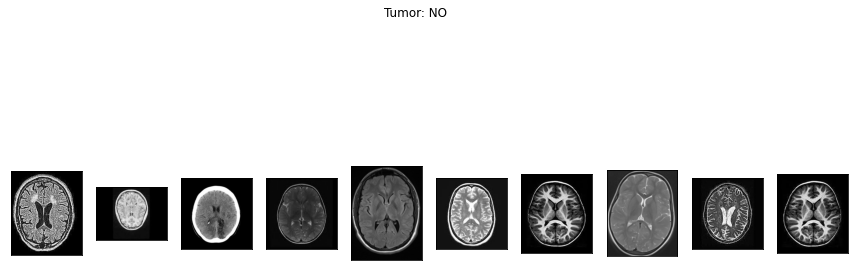

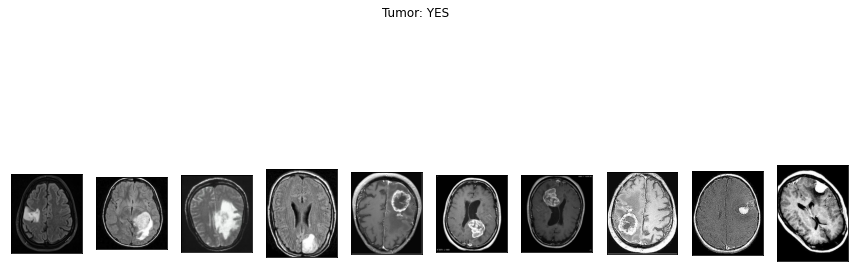

In [10]:
plot_samples(X_train, y_train, labels, 10)

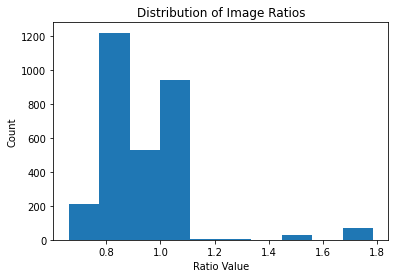

In [11]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [12]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
    return np.array(set_new)

In [13]:
img = cv2.imread('/content/drive/MyDrive/BR35H/yes/y1087.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

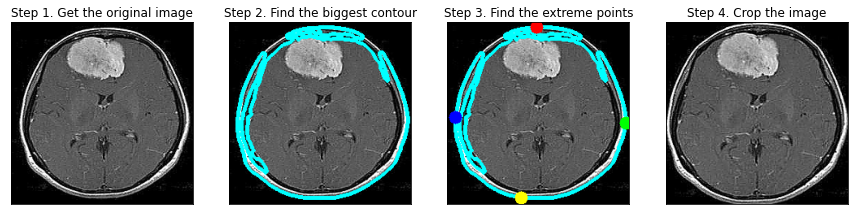

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [15]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

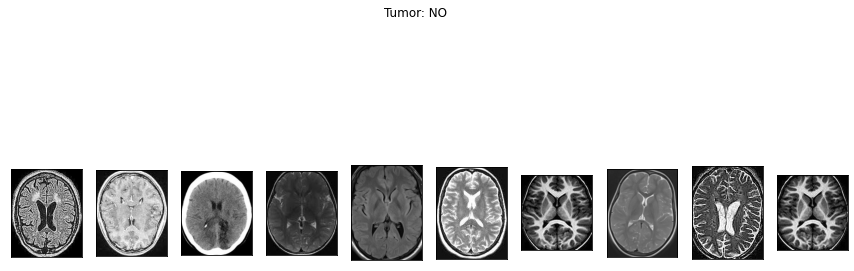

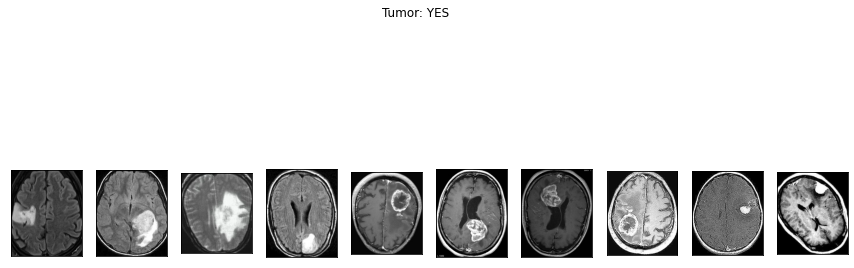

In [16]:
plot_samples(X_train_crop, y_train, labels, 10)

In [17]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [18]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [19]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [20]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [21]:
# plot_samples(X_train_prep, y_train, labels, 30)

In [22]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [23]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

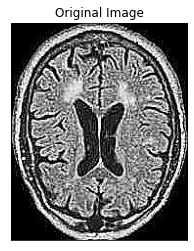

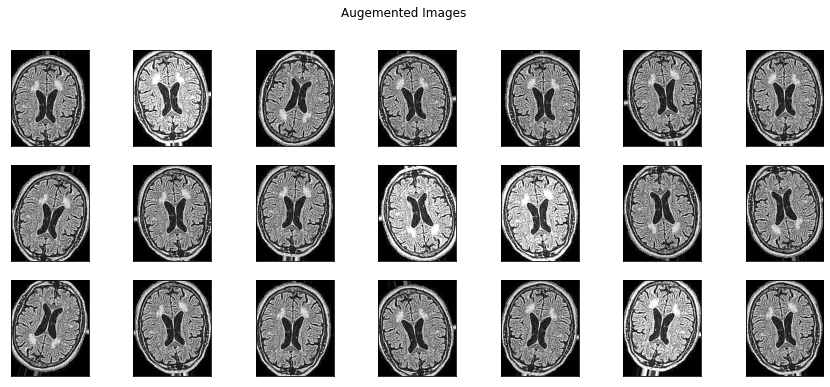

In [24]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [25]:
!rm -rf preview/

In [26]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [37]:
def build_lrfn(lr_start=0.0005, lr_max=0.001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn


In [38]:
import tensorflow.keras.layers as L

In [39]:
NUM_CLASSES = 1

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB3(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])
        
efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
    
efficientnet.summary()

44122112/44107200 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 7, 7, 1536)       10783528  
 )                                                               
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
______________________________________

In [40]:
#efficientnet.load_weights('../input/brain-tumor-detection-br35h/efficientnetb2_model.h5')

In [41]:
import time

start = time.time()

efficientnet_history = efficientnet.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/150
63/63 [==============================] - 96s 1s/step - loss: 0.5499 - accuracy: 0.8850 - val_loss: 0.8875 - val_accuracy: 0.9187
Epoch 2/150
63/63 [==============================] - 71s 1s/step - loss: 0.1291 - accuracy: 0.9610 - val_loss: 0.1211 - val_accuracy: 0.9771
Epoch 3/150
63/63 [==============================] - 71s 1s/step - loss: 0.0500 - accuracy: 0.9820 - val_loss: 0.0300 - val_accuracy: 0.9917
Epoch 4/150
63/63 [==============================] - 71s 1s/step - loss: 0.0975 - accuracy: 0.9735 - val_loss: 0.1408 - val_accuracy: 0.9771
Epoch 5/150
63/63 [==============================] - 71s 1s/step - loss: 0.0488 - accuracy: 0.9835 - val_loss: 0.0675 - val_accuracy: 0.9833
Epoch 6/150
63/63 [==============================] - 71s 1s/step - loss: 0.0295 - accuracy: 0.9930 - val_loss: 0.0880 - val_accuracy: 0.9875
Epoch 7/150
63/63 [==============================] - 71s 1s/step - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.0654 - val_accuracy: 0.9875
Epoch 8/150
6

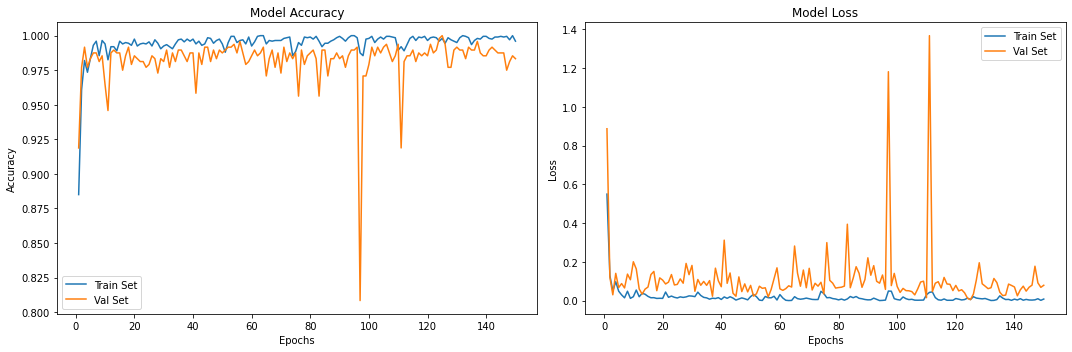

In [42]:
# plot model performance
acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs_range = range(1, len(efficientnet_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.9833


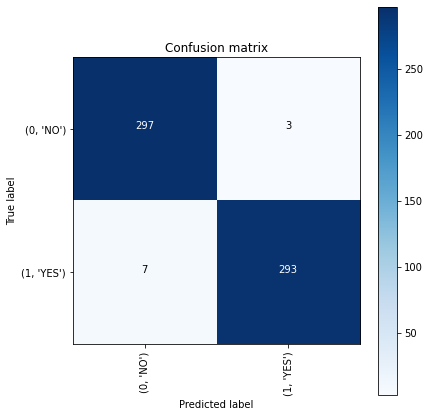

In [43]:
# validate on val set
predictions = efficientnet.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.4f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 1.0000


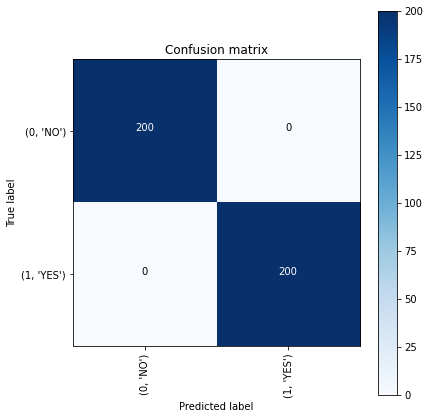

In [44]:
# validate on test set
predictions = efficientnet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [45]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
print
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

There are no missclassified images.
